# Comparison of the sigma measured with the different PMs aternatively and together

**CAVEAT:** the signal is mixed using just a Tee. This provokes delay, and attenuation on the sum that have to be estimated separately.


- sigma from the BWS acquisition
- sigma from the wire current acquisition --> TIMBER

In [1]:
# Quick fix for the usual Swan problems...
%run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-accuracy-measurement
Your IP is 172.17.0.6
2018-10-01 16:13:28


In [2]:
# %run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.09.21/'

matlabVars = ['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 64
                'PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_64_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_64_V_ROT.Acquisition.value.gain', 
                'PR_BWS_64_V_ROT.Acquisition.value.extraPMGain',                         
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.gain',
                'PR_BWS_85_V_ROT.Acquisition.value.extraPMGain',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples'
             ]

In [4]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 243 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.09.21//data/2018.09.21.19.26.59.393.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.09.21//data/2018.09.21.21.53.23.437.mat


In [5]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

In [6]:
# useful variables
myDataFrame['BWS85_PM1_on'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.gain'] > 0.
myDataFrame['BWS85_PM2_on'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.extraPMGain'] > 0.
myDataFrame['BWS64_PM1_on'] = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.gain'] > 0.
myDataFrame['BWS64_PM2_on'] = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.extraPMGain'] > 0.

# Data cleanup

In [7]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-21 19:34:43.900000'].name) # X wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-21 19:26:55.900000'].name) # Not retrived in TIMBER

Dropped 13 duplicate(s)
---
BPM data ok
---


# Save the imported data

In [8]:
myDataFrame.to_pickle('imported_data_2018.09.21.pkl')

In [9]:
# myDataFrame=pnd.read_pickle('imported_data_2018.09.21.pkl')

# Intensity

In [10]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity_max'] = [np.max(x) for x in myDataFrame['Intensity']]
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][85]/np.max(x) )

Text(0,0.5,u'Losses')

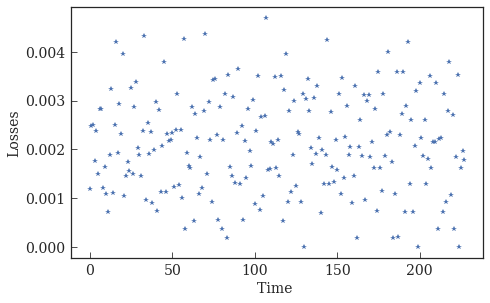

In [11]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

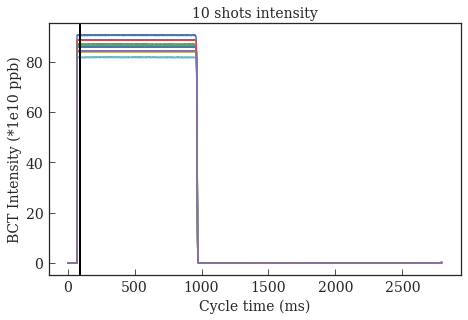

In [12]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=90, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner sigma

## BWS 85

In [13]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS85_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS85_sigma_y'] = myDataFrame['WS85_fit_results_y'].apply(lambda x: x[0][-1])

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [14]:
# cleanup the wirescanner acquired without trigger
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1'].iloc[113:] = np.nan
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.extraPMGain'].iloc[113:] = np.nan
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.gain'].iloc[113:] = np.nan
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[113:] = np.nan
myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].iloc[113:] = np.nan
myDataFrame['BWS85_position'].iloc[113:] = np.nan
myDataFrame['BWS85_position_idx'].iloc[113:] = np.nan
myDataFrame['BWS85_data'].iloc[113:] = np.nan
myDataFrame['BWS85_PM1_on'].iloc[113:] = np.nan
myDataFrame['BWS85_PM2_on'].iloc[113:] = np.nan
myDataFrame['WS85_fit_results_y'].iloc[113:] = np.nan
myDataFrame['WS85_sigma_y'].iloc[113:] = np.nan

## BWS 64

In [15]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS64_position'] = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS64_position_idx'] = myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS64_data'] = myDataFrame['BWS64_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS64_data'].iloc[r] = np.interp(pos, myDataFrame['BWS64_position'].iloc[r], myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS64_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS64_fit_results_y'] = myDataFrame['BWS64_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS64_sigma_y'] = myDataFrame['WS64_fit_results_y'].apply(lambda x: x[0][-1])

In [16]:
# cleanup the wirescanner acquired without trigger
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.acqTimeInCycleSet1'].iloc[0:113] = np.nan
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.extraPMGain'].iloc[0:113] = np.nan
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.gain'].iloc[0:113] = np.nan
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projDataSet1'].iloc[0:113] = np.nan
myDataFrame['PR_BWS_64_V_ROT.Acquisition.value.projPositionSet1'].iloc[0:113] = np.nan
myDataFrame['BWS64_position'].iloc[0:113] = np.nan
myDataFrame['BWS64_position_idx'].iloc[0:113] = np.nan
myDataFrame['BWS64_data'].iloc[0:113] = np.nan
myDataFrame['BWS64_PM1_on'].iloc[0:113] = np.nan
myDataFrame['BWS64_PM2_on'].iloc[0:113] = np.nan
myDataFrame['WS64_fit_results_y'].iloc[0:113] = np.nan
myDataFrame['WS64_sigma_y'].iloc[0:113] = np.nan

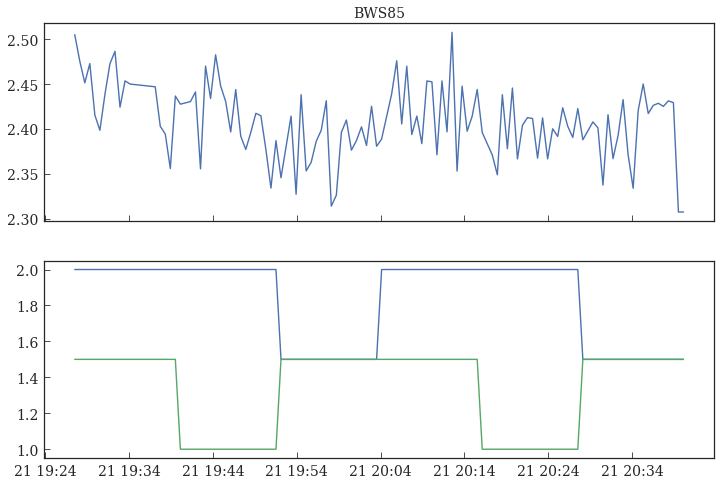

In [17]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
ax[0].plot(myDataFrame['WS85_sigma_y'])
ax[0].set_title('BWS85')
ax[1].plot(1.5+0.5*myDataFrame['BWS85_PM1_on'])
ax[1].plot(1+0.5*myDataFrame['BWS85_PM2_on'])

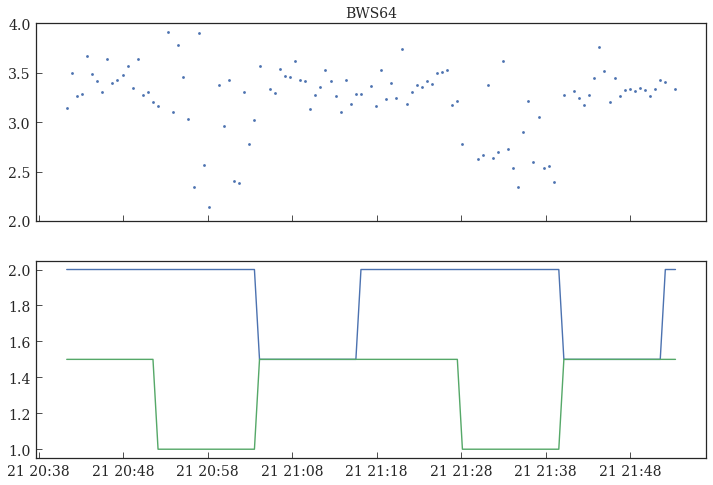

In [18]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
ax[0].plot(myDataFrame['WS64_sigma_y'],'.')
ax[0].set_title('BWS64')
ax[0].set_ylim(2, 4)
ax[1].plot(1.5+0.5*myDataFrame['BWS64_PM1_on'])
ax[1].plot(1+0.5*myDataFrame['BWS64_PM2_on'])

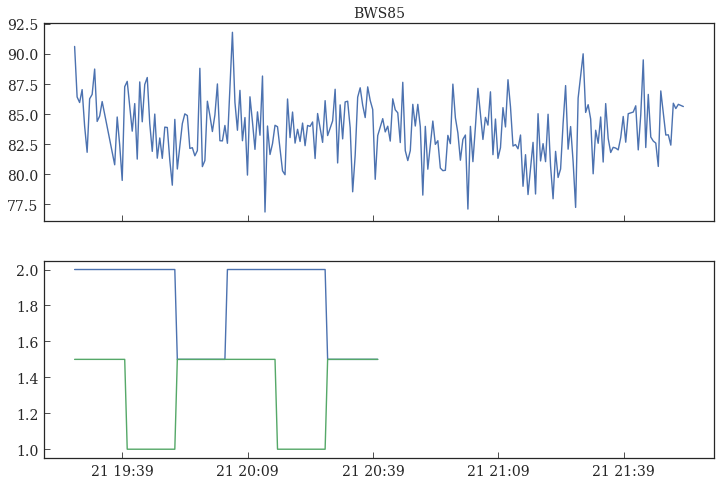

In [19]:
fig, ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax[0].plot(myDataFrame['Intensity_max'])
ax[0].set_title('BWS85')
ax[1].plot(1.5+0.5*myDataFrame['BWS85_PM1_on'])
ax[1].plot(1+0.5*myDataFrame['BWS85_PM2_on'])


sigma = 2.40301732942
Intensity = 83.88126


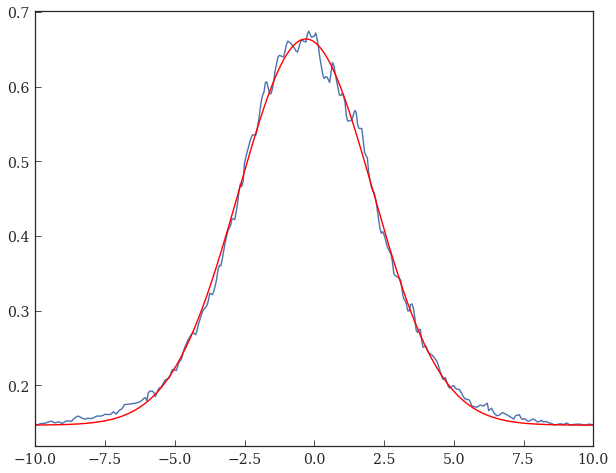

In [20]:
# one bad shot to exclude
k = 90
xx = pos
yy = myDataFrame['BWS85_data'].iloc[k]
fig, ax = plt.subplots(1, figsize=(10,8))
plt.plot(xx,yy)
yy2 = myToolbox.gaussian_5_parameters(pos,*myDataFrame['WS85_fit_results_y'].iloc[k][0])
plt.plot(xx,yy2,'r')

plt.xlim(-10,10)

print('sigma = '+str(myDataFrame['WS85_sigma_y'].iloc[k]))
print('Intensity = '+str(np.max(myDataFrame['Intensity'].iloc[k])))


### Calculate average emittance per measurement point

In [21]:
sigma_both_1 = np.mean(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True) & (myDataFrame['WS85_sigma_y']<2.55))][:19])
std_both_1 =np.std(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True) & (myDataFrame['WS85_sigma_y']<2.55))][:19])
sigma_both_2 = np.mean(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True))][19:])
std_both_2 = np.std(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True))][19:])

sigma_PM1_1 = np.mean(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][:19])
std_PM1_1 = np.std(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][:19])
sigma_PM1_2 = np.mean(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][19:])
std_PM1_2 = np.std(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][19:])

sigma_PM2_1 = np.mean(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][:19])
std_PM2_1 = np.std(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][:19])
sigma_PM2_2 = np.mean(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][19:])
std_PM2_2 = np.std(myDataFrame['WS85_sigma_y'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][19:])

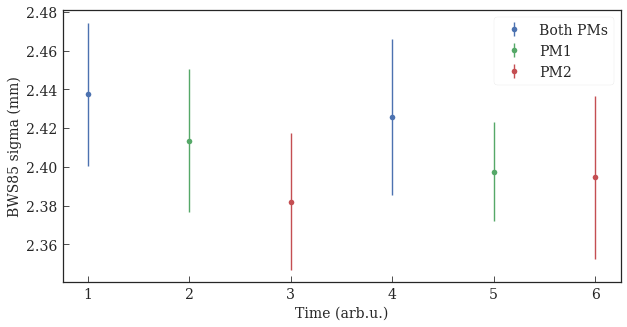

In [22]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.errorbar([1,4], [sigma_both_1, sigma_both_2], yerr=[std_both_1, std_both_2], fmt='o', label='Both PMs')
ax.errorbar([2,5], [sigma_PM1_1, sigma_PM1_2], yerr=[std_PM1_1, std_PM1_2], fmt='o', label='PM1')
ax.errorbar([3,6], [sigma_PM2_1, sigma_PM2_2], yerr=[std_PM2_1, std_PM2_2], fmt='o', label='PM2')

ax.set_xlabel('Time (arb.u.)')
ax.set_ylabel('BWS85 sigma (mm)')

ax.legend(frameon=True)

## Correlation intensity / beam sigma

(array([ 1.40656949,  0.01191011]), array([  7.71095801e-03,   1.08947512e-06]))


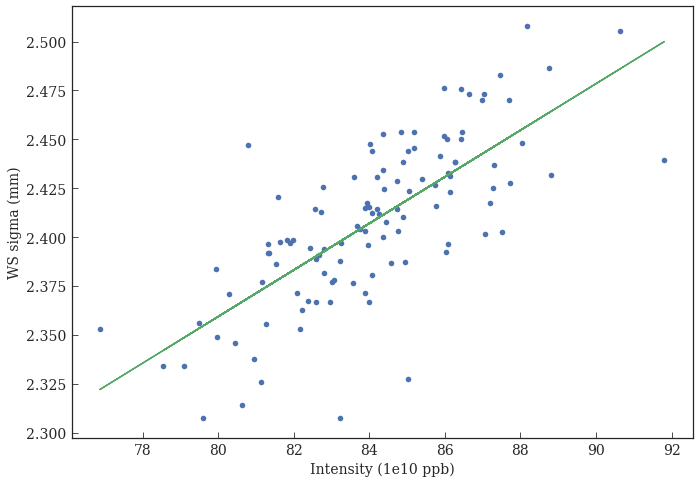

In [23]:
# find correlation parameter 
xx = myDataFrame['Intensity_max'][:113]
yy = myDataFrame['WS85_sigma_y'][:113]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(xx, yy, 'o')
ax.set_xlabel('Intensity (1e10 ppb)')
ax.set_ylabel('WS sigma (mm)')

from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [24]:
def scale_sigma(intensity, sigma):
    '''
    Scale the sigma due to the Intensity of 85e10 ppb
    '''
    a = 1.41546154
    b = 0.01181483
    
    corr_factor = lin(intensity, a, b) / lin(85, a, b)
    return sigma/corr_factor

myDataFrame['WS85_sigma_y_corrected'] = scale_sigma(myDataFrame['Intensity_max'][:113], myDataFrame['WS85_sigma_y'][:113])
myDataFrame['WS64_sigma_y_corrected'] = scale_sigma(myDataFrame['Intensity_max'][113:], myDataFrame['WS85_sigma_y'][113:])


### Ok now recalculate all using the corrected sigmas

In [25]:
sigma_both_1 = np.mean(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True) & (myDataFrame['WS85_sigma_y']<2.55))][:19])
std_both_1 =np.std(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True) & (myDataFrame['WS85_sigma_y']<2.55))][:19])
sigma_both_2 = np.mean(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True))][19:])
std_both_2 = np.std(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==True))][19:])

sigma_PM1_1 = np.mean(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][:19])
std_PM1_1 = np.std(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][:19])
sigma_PM1_2 = np.mean(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][19:])
std_PM1_2 = np.std(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==True) & (myDataFrame['BWS85_PM2_on']==False))][19:])

sigma_PM2_1 = np.mean(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][:19])
std_PM2_1 = np.std(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][:19])
sigma_PM2_2 = np.mean(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][19:])
std_PM2_2 = np.std(myDataFrame['WS85_sigma_y_corrected'].loc[((myDataFrame['BWS85_PM1_on']==False) & (myDataFrame['BWS85_PM2_on']==True))][19:])

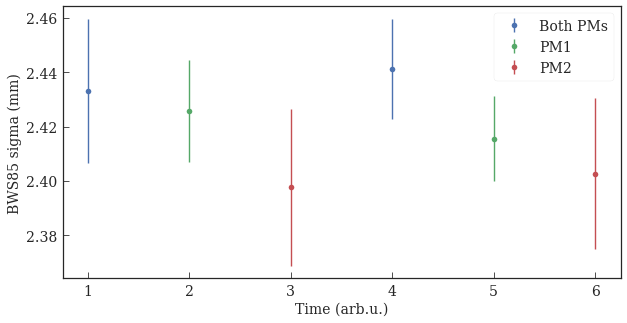

In [26]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.errorbar([1,4], [sigma_both_1, sigma_both_2], yerr=[std_both_1, std_both_2], fmt='o', label='Both PMs')
ax.errorbar([2,5], [sigma_PM1_1, sigma_PM1_2], yerr=[std_PM1_1, std_PM1_2], fmt='o', label='PM1')
ax.errorbar([3,6], [sigma_PM2_1, sigma_PM2_2], yerr=[std_PM2_1, std_PM2_2], fmt='o', label='PM2')

ax.set_xlabel('Time (arb.u.)')
ax.set_ylabel('BWS85 sigma (mm)')

ax.legend(frameon=True)

# Get the wire current from Timber

In [27]:
# get data from TIMBER
t1 = '2018-09-21 19:25:00.000'
# t2 = '2018-09-21 20:50:00.000' #switch trigger from BWS85 to 64
t3 = '2018-09-21 23:00:00.000'
wireDf = myToolbox.cals2pnd(['PR.BWS.85.V_ROT:RESITANCE_IN', 'PR.BWS.64.V_ROT:RESITANCE_IN'], t1, t3)

In [28]:
myDataFrame['PR.BWS.64.V_ROT:RESITANCE_IN'] = [np.empty(0, dtype=float)]*len(myDataFrame)
myDataFrame['PR.BWS.85.V_ROT:RESITANCE_IN'] = [np.empty(0, dtype=float)]*len(myDataFrame)
myDataFrame['Resistance_ts'] = str()
# match the data to the mytoolbox dataframe
for wireIndex in wireDf.index:
    for dfIndex in myDataFrame.index:
        
        if wireIndex == dfIndex:
            myDataFrame['Resistance_ts'].loc[dfIndex] = wireIndex
            myDataFrame['PR.BWS.85.V_ROT:RESITANCE_IN'].loc[dfIndex] = wireDf['PR.BWS.85.V_ROT:RESITANCE_IN'].loc[wireIndex]
            myDataFrame['PR.BWS.64.V_ROT:RESITANCE_IN'].loc[dfIndex] = wireDf['PR.BWS.64.V_ROT:RESITANCE_IN'].loc[wireIndex]

In [29]:
#manual fixies
myDataFrame['Resistance_ts'].loc['2018-09-21 19:26:55.900000'] = np.nan
myDataFrame['PR.BWS.85.V_ROT:RESITANCE_IN'].loc['2018-09-21 19:26:55.900000'] = np.nan
myDataFrame['PR.BWS.64.V_ROT:RESITANCE_IN'].loc['2018-09-21 19:26:55.900000'] = np.nan

# myDataFrame[['Resistance_ts','PR.BWS.85.V_ROT:RESITANCE_IN','PR.BWS.64.V_ROT:RESITANCE_IN']]

In [96]:
# first tranche, BWS85 was used
# myDataFrame['PR.BWS.85.V_ROT:RESITANCE_IN'].iloc[:112]


# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data_current'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape
row = 110 # manual fix

for r in xrange(row):
    print(r)
    myDataFrame['BWS85_data_current'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR.BWS.85.V_ROT:RESITANCE_IN'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS85_fit_results_y_current'] = myDataFrame['BWS85_data_current'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS85_sigma_y_current'] = myDataFrame['WS85_fit_results_y_current'].apply(lambda x: x[0][-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


IndexError: index 1080 is out of bounds for axis 1 with size 1080

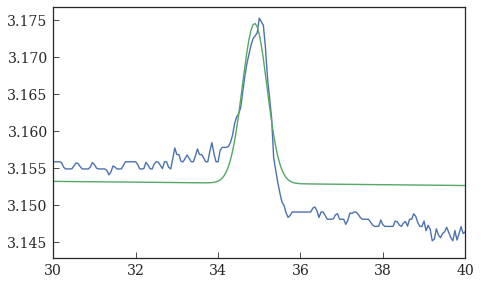

In [102]:
plt.plot(pos, myDataFrame['BWS85_data_current'].iloc[0])
plt.xlim(30,40)
gauss = myToolbox.makeGaussianFit_5_parameters(pos, myDataFrame['BWS85_data_current'].iloc[0])
plt.plot(pos, myToolbox.gaussian_5_parameters(pos, *gauss[0]))